# ETF Spread

研究目的：
-  针对不同ETF进行验证，小盘、大盘的ETF之间是否会存在利差
-  进行线性回归，针对线性回归确定beta和alpha，针对残差进行分析
-  残差是否符合正态分布，是否需要采用log处理
-  验证了是否cointegration，是否stationary
-  引入kalman filter，不需要进行windows设置

## 步骤1

提取有效的ETF数据信息

In [63]:
import numpy as np
import pandas as pd

import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')

In [64]:
# 获得全量ETF列表
get_all_securities(['fund']).to_csv("etf_list.csv")

In [65]:
# 候选ETF
# 510050：上证50ETF
# 159919：沪深300ETF
# 510500：中证500
# 512100：中证1000
# 159915：易方达创业板指数

# ETF是一揽子股票，没有相应组成部分，只能从字面上理解相应的组成，通过指数来进行模拟

candidate_ETF = [
    "510050.XSHG",
    "159919.XSHE",
    "510500.XSHG",
    "512100.XSHG",
    "159915.XSHE"
]


# 确定整体时间长度，默认设置为过去200天
ncount = 300

# 确定end_date
end_date='2024-04-15'

In [66]:
# 生成价格pandas数组
price_pd = pd.DataFrame()


for ETF_i in candidate_ETF:
    
    # 初始变量命名
    ETF_i_name = ""
    ETF_i_name = str(ETF_i[:6]) + "_ETF"
    
    # 显示过程
    print(ETF_i_name)

    # 提取价格数据
    price_ETF_temp = pd.DataFrame()
    price_ETF_temp = get_price(ETF_i, count = ncount, end_date=end_date, frequency='daily', fields=['close'])['close']
    price_ETF_temp.name = ETF_i_name
    
    # 数据合并
    price_pd = pd.concat([price_pd,price_ETF_temp], axis = 1)


510050_ETF
159919_ETF
510500_ETF
512100_ETF
159915_ETF


In [67]:
price_pd.head()

,510050_ETF,159919_ETF,510500_ETF,512100_ETF,159915_ETF
2023-01-16,2.802,4.208,6.143,2.636,2.462
2023-01-17,2.793,4.210,6.151,2.633,2.470
2023-01-18,2.774,4.199,6.175,2.641,2.468
2023-01-19,2.784,4.232,6.232,2.672,2.496
2023-01-20,2.803,4.253,6.277,2.697,2.507


## 步骤2

对数据进行分析，直接使用价格数据进行模拟建模



In [68]:
# plt的默认设置
plt.rcParams['figure.figsize'] = [12.0, 8.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

In [69]:
# 确定X、Y变量

# 初始设置，以沪深300为X变量基准，以上证50为Y变量
X_benchmark =  price_pd['159919_ETF']
Y_pred = price_pd['510050_ETF']

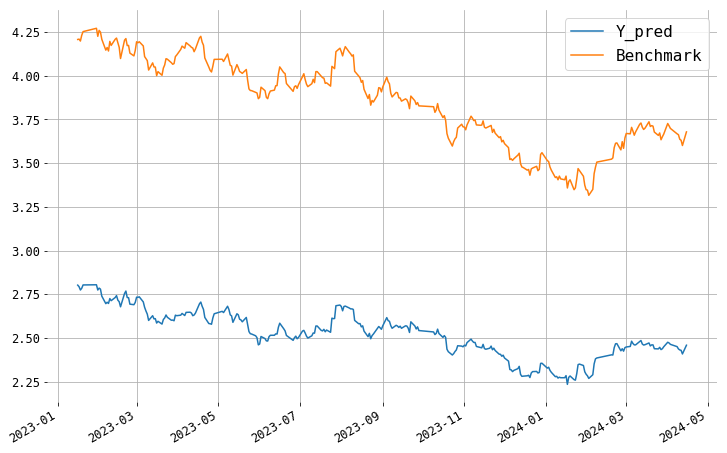

In [70]:
# 进行画图
pd.concat([Y_pred, X_benchmark], axis=1).plot()
plt.legend(['Y_pred', 'Benchmark']);

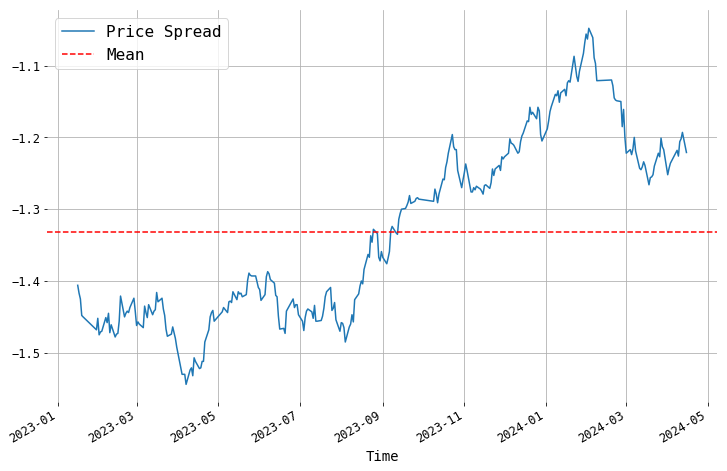

In [71]:
# 画出价格变化趋势
(Y_pred -  X_benchmark).plot() # Plot the spread
plt.axhline((Y_pred -  X_benchmark).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean']);

## Step3：计算spread

1. 使用线性拟合的beta进行调整
2. 使用了zscore

In [72]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

In [73]:
X_benchmark_const = sm.add_constant(X_benchmark)
results = sm.OLS(Y_pred, X_benchmark_const).fit()

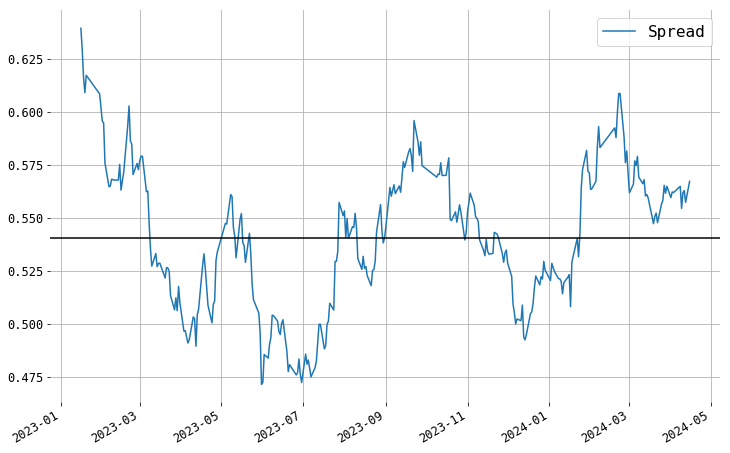

In [74]:
b = results.params['159919_ETF']

spread = Y_pred - b * X_benchmark
spread
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

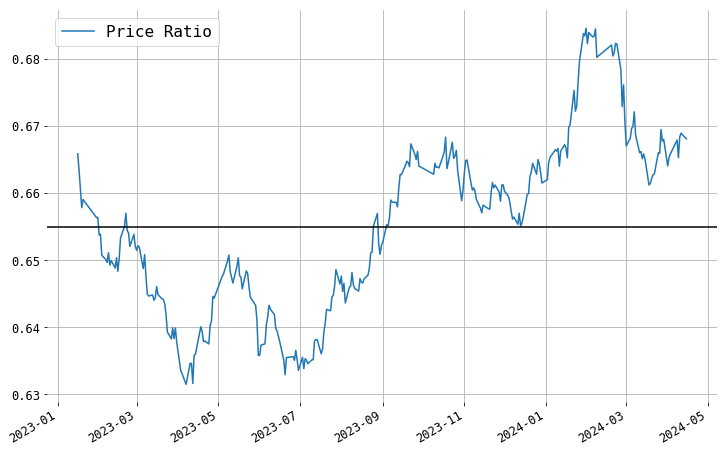

In [75]:
ratio = Y_pred / X_benchmark
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

**如果单纯看图的话，beta调整相应的围绕均值波动比较准确，ratio和price都不是stationary**

In [76]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

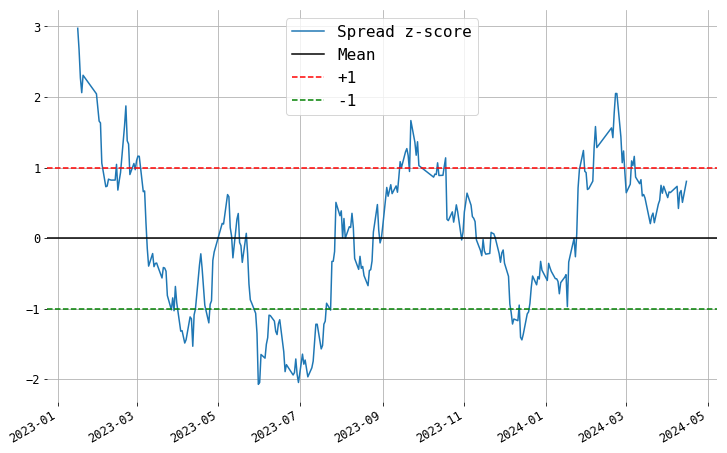

In [77]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

## Step4：使用rolling windows进行跟踪

1. 因为版本问题，rolling ols使用pyfinance进行
2. beta不稳定，前期数据不足，数值为负，后期转为正数，先后数据待参考
3. 设置为100天，则beta较为稳定，符合经验值

In [81]:
from pyfinance.ols import PandasRollingOLS

# 设置windows大小
n_windows = 100

ret = PandasRollingOLS(y=Y_pred , x=X_benchmark, window=n_windows)

rolling_beta = ret.beta


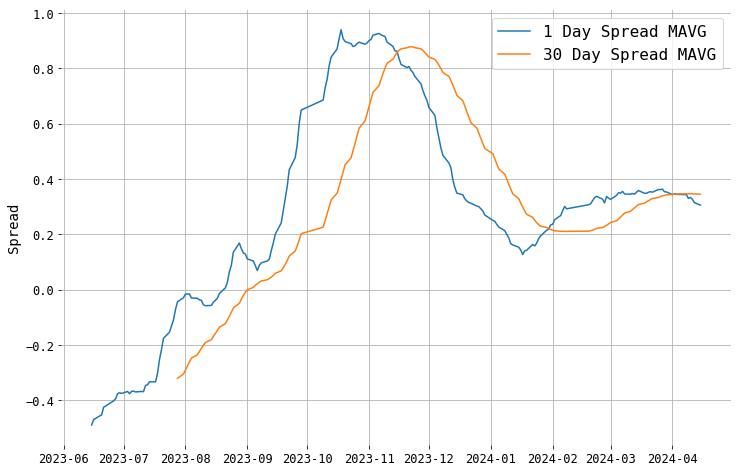

In [82]:
spread = Y_pred - rolling_beta['feature1'] * X_benchmark
spread.name = 'spread'

spread_mavg1 = spread.rolling(1).mean()
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');

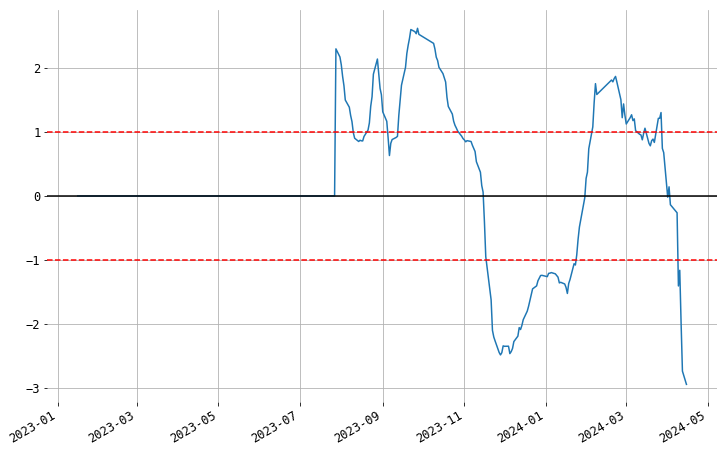

In [83]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.fillna(0,inplace = True)
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='red', linestyle='--')

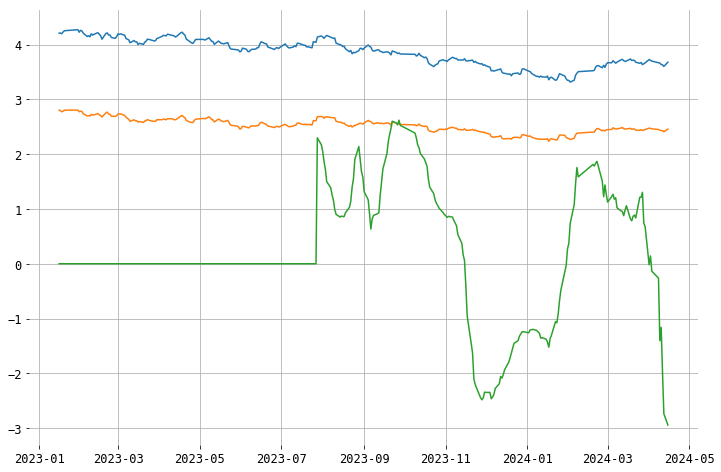

In [84]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(X_benchmark.index, X_benchmark.values)
plt.plot(Y_pred.index, Y_pred.values)
plt.plot(zscore_30_1.index, zscore_30_1.values)



In [85]:
# 检测是否正态分布
from statsmodels.stats.stattools import jarque_bera

normality_pvalue = jarque_bera(zscore_30_1)[1]
normality_pvalue

0.07979865117793244

In [86]:
# 检测是否stationary
from statsmodels.tsa.stattools import coint, adfuller

stationary_pvalue = adfuller(zscore_30_1)[1]
stationary_pvalue

0.16729528778431413